In [84]:
# Task description:
#У меня есть 985 комментариев о работе компании и пожеланиях клиентов. 
#1. Нужно получить коэффициенты сентиментов по каждому, то есть насколько комментарий 
#положительный или отрицательный (NLTK.sentiments for english and Dostoevsky for russian comments). 
#2. Также желательно определить, к каким отделам относятся 
#эти комментарии, чтобы понять, кому их надо брать в работу (Latent Dirichlet Allocation (LDA) for english comments and Natasha for russian coments). 
#3. Задача максимум: ещё и связать 
# коэффициенты сентиментов с количественными оценками, которые клиенты выставляли по 
# отдельным критериям работы компании. Вы такое умеете делать (customer loyalty)?

In [107]:
import pandas as pd #импорт модуля пандас под именем пд, необходимого для работы с таблицей из экселя
from string import punctuation #импорт объекта для удаления знаков препинания между словами
import os, os.path, subprocess
import math

# English language
import nltk #импорт пакета nltk для NLP
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords #импорт объекта для удаления лишних (стоп) слов из модуля corpus из пакета nltk для NLP
from nltk.stem import WordNetLemmatizer
# Lemmatize with POS Tag
from nltk.corpus import wordnet

nltk.download([
    "punkt",
    "stopwords",
    "averaged_perceptron_tagger",
    "wordnet"
])

#Russian language analyzer
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

from IPython.display import Image
from PIL import Image

# Import required libraries
from nltk import pos_tag, word_tokenize, RegexpParser

# Visualization 
import numpy as np # Import numpy lib
from numpy import convolve # 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#Global variables documents
docPath = "/Users/lucifer/Desktop/20220504_DataScience_Python_NLTK_PROFI.ru_Nelya/Data/Excel2.xlsx"

#Global variables libraries
pathModel = "/Users/lucifer/Desktop/20220504_DataScience_Python_NLTK_PROFI.ru_Nelya/Libraries/fasttext-social-network-model.bin"

# Global variables for NLTK Tree 
path='/Users/lucifer/Desktop/20220504_DataScience_Python_NLTK_PROFI.ru_Nelya/Bin/output.ps'
outputPath = '/Users/lucifer/Desktop/20220504_DataScience_Python_NLTK_PROFI.ru_Nelya/Bin/output.ps'
nltkTreePath = '/Users/lucifer/Desktop/20220504_DataScience_Python_NLTK_PROFI.ru_Nelya/Bin/output.png'


[nltk_data] Downloading package punkt to /Users/lucifer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucifer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucifer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/lucifer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [106]:
def Setup(path: str):# = os.path.abspath(input("Enter path of your Excel document: "))):       
    if len(path) == 0:
        raise ValueError('Argument empty', type(path))
    
    try:
         return pd.read_excel(path,usecols='A,J') #выбираем только колонки A, J для идентификации и анализа
    except OSError:
        if not os.path.isfile(path):
            print("Excel document isn't exist")

def GetDataFromDocByKey(document: list, key: str) -> list:
    if len(document) == 0:
        raise ValueError('Argument empty', type(document))
        
    if len(key) == 0:
        raise ValueError('Argument empty', type(key))  
    
    return document[key].astype(str).tolist()            

# TODO: It isn't best code it should be ovewrited to follow SOLID principles  
def matchrus(text: str, alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')) -> bool:
    return not alphabet.isdisjoint(text.lower()) #функция для проверки, если комментарий написан на русском

# TODO: It isn't best code it should be ovewrited to follow SOLID principles 
def matcheng(text: str, alphabet = set('abcdefghijklmnopqrstuvwxyz')) -> bool:
    return not alphabet.isdisjoint(text.lower()) #функция для проверки, если комментарий написан на английском
    # x - 'a' >= 0 && x - 'a' <= 26
    
def GetCommentsRusOrEng(clientsIds: list, comments: list) -> list:
    if len(clientsIds) == 0:
        raise ValueError('Argument empty', type(clientsIds))
        
    if len(comments) == 0:
        raise ValueError('Argument empty', type(comments))
    
    # Space complicty O(N)
    russiancomments = [] # создаем три пустых массива, чтобы в них записать, соответственно, комментарии на русском
    # Space complicty O(N)
    englishcomments = [] # на английском
    # Space complicty O(N)
    nulcomments = [] # и "нулевые"
    
    # цикл, который исполняется для каждого id клиента
    # Time complicty: O(N)
    for i in range(0, len(clientsIds)):
        comment = comments[i]

        # TODO: Refactoring - I think, it's possible to move the check to a separate method
        if matchrus(comment):
            # если комментарий на русском, записываем в массив для руссских комментариев
            russiancomments.append(comment) 
        elif matcheng(comment):
            # аналогично для английского
            englishcomments.append(comment) 
        else:
            # оставшиеся попадают в "нулевой" массив
            nulcomments.append(comment)
            
    # Space complicty O(N + N + N or 3N) and Time complicty: O(N)       
    return russiancomments, englishcomments, nulcomments

def PrintComments(comments: list, lang: str) -> None:
    if len(comments) == 0:
        raise ValueError('Argument empty', type(comments))
        
    if len(lang) == 0:
        raise ValueError('Argument empty', type(lang))
    
    print(f"{lang} comments", comments)
    
def GetStopwords(lang: str) -> list:
    if len(lang) == 0:
        raise ValueError('Argument empty', type(lang))
    
    return stopwords.words(lang)

def GetTokensOrWords(comments: list, stopwords = None, punctuation = None) -> []:
    if len(comments) == 0:
        raise ValueError('Argument empty', type(comments))
    
    if stopwords is not None and len(stopwords) == 0:
        raise ValueError('Argument empty', type(stopwords))
        
    if punctuation is not None and len(punctuation) == 0:
        raise ValueError('Argument empty', type(punctuation))
    
    # Space complicty: O(N)
    words = []
    
    # Time complicty: O(N)
    for i in range(0, len(comments)): #делим тексты на токены, то есть на отдельные слова, выкидывая знаки препинания и стоп-слова
        #text = comments[i][2] # jagged array
        text = comments[i]
        tokens = nltk.word_tokenize(text.lower())
        if stopwords is not None and punctuation is not None:
            words.append([token for token in tokens if token not in stopwords and token not in punctuation])
    
    # Time complicty: O(N) and Space complicty: O(N)
    return words
    
def LemmatizationSentences(sentences: list, tag: bool = False) -> []:
    if sentences is not None and len(sentences) == 0:
        raise ValueError('Argument empty', type(sentences))
    
    lemmatizer = WordNetLemmatizer()
    #tokenization = nltk.word_tokenize(text)
    lemmatized_sentences = []
    # Time complicty: O(N)
    for words in sentences:
        # Time complicty: O(N)
        lemmatized_words = [LemmatizingWord(word, GetWordnetPos(word)) if tag == True else LemmatizingWord(word) for word in words]
        lemmatized_sentences.append(lemmatized_words)
    
    # Time complicty: O(N^2) and Space complicty: O(N)
    return lemmatized_sentences

def LemmatizingWord(word: str, tag: str = None) -> str:
    if word is not None and len(word) == 0:
        raise ValueError('Argument empty', type(sentences))
    
    lemmatizer = WordNetLemmatizer()
    lemmatized = lemmatizer.lemmatize(word) if tag is None else lemmatizer.lemmatize(word, tag)
    return lemmatized

def IsCommentPositive(sia, comment: str, percents: bool = False) -> bool:
    if sia == None:
        raise ValueError('Argument empty', type(sia))
    
    if len(comment) == 0:
        raise ValueError('Argument empty', type(comment))
        
    """True if comment has positive compound sentiment, False otherwise."""
    return sia.polarity_scores(comment)["compound"] > 0 

# English coments sentiemnt analysis
# Compund or aggregate (true is Positive or false is Negative) 
def IsCommentPositivePercents(sia, comment: str) -> float:
    if sia == None:
        raise ValueError('Argument empty', type(sia))
    
    if len(comment) == 0:
        raise ValueError('Argument empty', type(comment))
        
    """True if comment has positive compound sentiment, False otherwise."""
    return sia.polarity_scores(comment)["pos"], sia.polarity_scores(comment)["neg"], sia.polarity_scores(comment)["neu"]

def PrintSentiments(sia, comments: []) -> None:
    if sia is None:
        raise ValueError('Argument empty', type(sia))
    
    if len(comments) == 0:
        raise ValueError('Argument empty', type(comments))
    
    for comment in comments:
        print(">", "Positive:" if IsCommentPositive(sia, comment) else "Negative:", comment)

def SentimentAnalyses(comments: [], lang: str = "Eng") -> None:
    if len(comments) == 0:
        raise ValueError('Argument empty', type(comments))
    
    if len(lang) == 0:
        raise ValueError('Argument empty', type(lang))
    
    print(f"Sentiment Analysis of {lang}")
    #if lang is "Russian" or lang is "Rus":
    if lang == "English" or lang == "Eng":
        sia = SentimentIntensityAnalyzer()
        PrintSentiments(sia, comments)
        
# Russian coments sentiemnt analysis
def GetRussianSentimentsFrom(comments: list, pathModel: str) -> list:   
    if len(comments) == 0:
        raise ValueError('Argument empty', type(comments))
        
    if len(pathModel) == 0:
        raise ValueError('Argument empty', type(comments))
    
    tokenizer = RegexTokenizer()
    FastTextSocialNetworkModel.MODEL_PATH = pathModel
    sia = FastTextSocialNetworkModel(tokenizer=tokenizer)
    return sia.predict(comments)

# Create X and Y axis pints on coordinate system  
def GetSentiementByKey(sentence, key):
    return list(map(lambda sentiment: sentiment[key], sentiments))

def CrateTree(sentence: list, outputPath: str) -> bool:
    if len(sentence) == 0:
        raise ValueError('Argument empty', type(words))   
      
    if len(outputPath) == 0:
        raise ValueError('Argument empty', type(outputPath))
    
    #Extract all parts of speech from any text
    chunker = RegexpParser("""
        NP: {<DT>?<JJ>*<NN>} #To extract Noun Phrases
        P: {<IN>}            #To extract Prepositions
        V: {<V.*>}           #To extract Verbs
        PP: {<p> <NP>}       #To extract Prepositional Phrases
        VP: {<V> <NP|PP>*}   #To extract Verb Phrases
        """)
    # Find all parts of speech in above sentence
    try:
        words = word_tokenize(sentence)
        tagged = pos_tag(words)
        chunked = chunker.parse(tagged)
        nltk.draw.tree.TreeView(chunked)._cframe.print_to_file(outputPath)
        return True
    except OSError:
        print(f"Error accured {OSError}")
        return False
    
def ConvertToPng(path: str) -> bool:
    if len(path) == 0:
        raise ValueError('Argument empty', type(path))  
    
    try:
        img = Image.open(path)
        img.save("output.png")
        return True
    except OSError:
        print(f"Error accured {OSError}")
        return False
    
def GetWordnetPos(word: str) -> str:
    if len(word) == 0:
        raise ValueError('Argument empty', type(word))  
    
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Quantity or count of comments 
def Count(comments: list, greater: float = 0.6):    
    if len(comments) == 0:
        raise ValueError('Argument empty', type(comments))  
    
    return sum(percent > greater for percent in comments)

def FromWordsToSentence(sentence: list) -> list:
    if len(sentence) == 0:
        raise ValueError('Argument empty', type(sentence))  
    
    return ' '.join(sentence)

def FromWordsToSentences(sentences_words: list) -> list:
    if len(sentences_words) == 0:
        raise ValueError('Argument empty', type(sentences_words))  
    
    return [FromWordsToSentence(words) for words in sentences_words]

In [77]:
survey = Setup(docPath)
comments = GetDataFromDocByKey(survey, "Комментарий клиента") #создаем массив только с комментариями
clientsIds = GetDataFromDocByKey(survey, "Id шаблона") #создаем массив только с id клиента 
russiancomments, englishcomments, nulcomments = GetCommentsRusOrEng(clientsIds, comments)
russian_stopwords = GetStopwords("russian")
english_stopwords = GetStopwords("english")
russianWords = GetTokensOrWords(russiancomments, russian_stopwords, punctuation)
englishWords = GetTokensOrWords(englishcomments, english_stopwords, punctuation)
lemmatizedenglishwords = LemmatizationSentences(englishWords, True)
nulWords = GetTokensOrWords(nulcomments)

In [9]:
#получился массив в массиве на самом деле, но для простоты понимания ниже буду называть массивы в массиве строчками
PrintComments(russiancomments, "Russia")
PrintComments(englishcomments, "English")
PrintComments(nulcomments, "Nul")
print("\n\r")

print("Amount of Russia comments: ", len(russiancomments)) #печатаем количество строк в каждом массиве
print("Amount of English comments: ", len(englishcomments)) #так их можно сложить и ерепроверить, что сумма сошлась верно
print("Amount of Nul comments: ", len(nulcomments)) #можно это и булевой функцией записать коротко, но пока нужна наглядность для корректировки
print("\n\r")

print(russian_stopwords) #печатаем русские лишние (стоп) слова из пакета nltk, чтобы понимать, что будем дальше выкидывать
print(english_stopwords) #для английского отдельно

print ("Russian words", russianWords)
print ("English words", englishWords)
print ("Nul words", nulWords)
print("\n\r")

print("Sentiment analysis (comment is psitive or negative):")
SentimentAnalyses(englishcomments)

Russia comments ['В целом всё хорошо, но иногда допускаются ошибки в оформлении документов.', 'все Вы делаете хорошо', 'ранее указывали, хотелось бы в ускоренном варианте получать счета фактуры, для возможности оприходования материала и корректной подачи ЗОВ день в день.', 'Поздно поступают документы по отгрузке .', 'встречаются ошибки по количеству. но редко', 'После перехода на ЭДО', 'С документами все четко.', 'Медленно подписываются дополнения на подтвержденный объем', 'Нет электронного документа УПД по отгрузке ДОТФ 24.10.2020.', 'Документы по ЭДО отправляются позже, чем машина приходит  на разгрузку', 'В 2020г. имелись проблемы с предоставлением оригиналов отгрузочных документов и ДС', 'Сроки выставления корректирующих документов в случае выявления расхождений оставляют желать лучшего', 'есть проблемы и "неудобство" в связи с использованием каждой стороной своего ПО для внутреннего согласования документов.', 'нет синхронизации работы по авансовым с/ф. Переодический перекос в нало

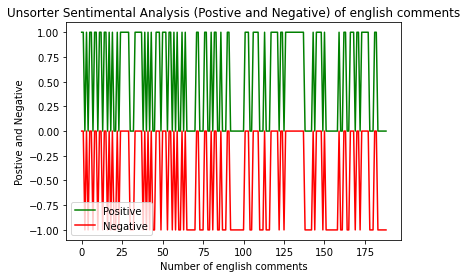

The quantity of Positive comments: 98
The quantity of Negative comments: 91
The overall or total of comments: 690


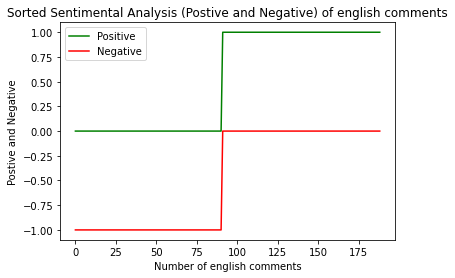

Positive comments percents 14%
Negative comments percents 13%
The quantity of Positive comments: 98
The quantity of Negative comments: 91
The overall or total of comments: 690


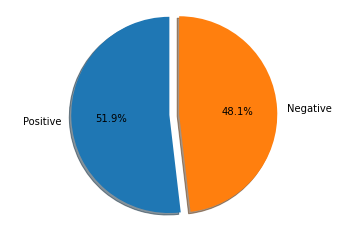

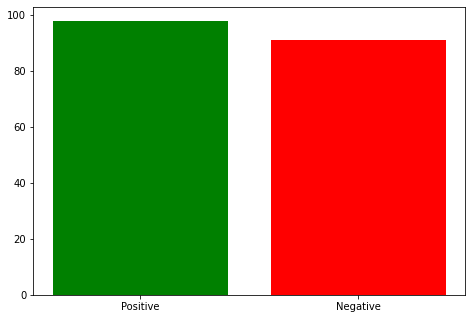

In [105]:
# English coments sentiemnt analysis (negative or positive -1 or 1)
sia = SentimentIntensityAnalyzer()
sentiments = [(1, 0) if IsCommentPositive(sia, comment) else (0, -1) for comment in englishcomments] #в Y сразу две Y-координаты, первая -- позитивные комменатрии, вторая -- негативные

# Create X and Y axis 
overall = len(x_num)
x_num = list(range(0, len(lemmatizedenglishwords)))
y_pos = GetSentiementByKey(sentiments, 0)
y_neg = GetSentiementByKey(sentiments, 1)

# Draw plot
plt.title('Unsorter Sentimental Analysis (Postive and Negative) of english comments')
plt.ylabel('Postive and Negative')
plt.xlabel('Number of english comments')
plt.plot(x_num, y_pos, "-g") #g -- green
plt.plot(x_num, y_neg, "-r") #r -- red. Например, b -- blue
plt.legend(['Positive', 'Negative']) #подписывает цвета
plt.show()

y_sorted_pos = sorted(y_pos) #отсортированы от меньшего к большему
y_sorted_neg = sorted(y_neg)

# Draw plots
plt.title('Sorted Sentimental Analysis (Postive and Negative) of english comments')
plt.ylabel('Postive and Negative')
plt.xlabel('Number of english comments')
plt.plot(x_num, y_sorted_pos, "-g")
plt.plot(x_num, y_sorted_neg, "-r")
plt.legend(['Positive', 'Negative'])

print(f"The quantity of Positive comments: {y_sorted_pos.count(1)}")
print(f"The quantity of Negative comments: {y_sorted_neg.count(-1)}")
print(f"The overall or total of comments: {overall}")

plt.show()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:

# Calculation of ratio
# Positive ratio
#189 = 100%
#98 = percent

# Negative ratio
#189 = 100%
#91 = percent

pos_percent = round(y_pos.count(1) * 100 / overall) #процент положительных комменатриев
neg_percent = round(y_neg.count(-1) * 100 / overall)

print(f"Positive comments percents {round(y_pos.count(1) * 100 / overall)}%")
print(f"Negative comments percents {round(y_neg.count(-1) * 100 / overall)}%")

#pie chart
labels = 'Positive', 'Negative'
sizes = [pos_percent, neg_percent]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
#0,1 -- расстояние между кусками пирога

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print(f"The quantity of Positive comments: {y_pos.count(1)}")
print(f"The quantity of Negative comments: {y_neg.count(-1)}")
print(f"The overall or total of comments: {overall}")

plt.show()

# Draw chart bar
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiments = ['Positive', 'Negative']
comments = [y_pos.count(1), y_neg.count(-1)]
ax.bar(sentiments, comments, color = ['g', 'r'])
plt.show()

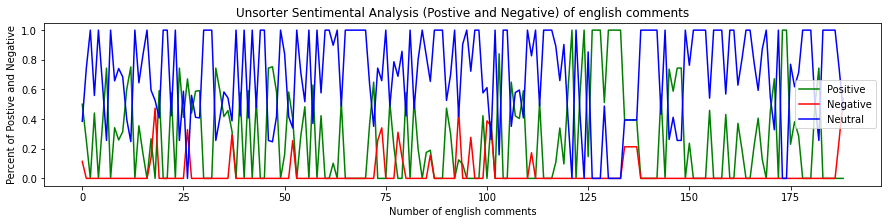

The quantity of comments
The quantity of Positive: 28
The quantity of Negative: 0
The quantity of Neutral: 112
The quantity of rest comments: 49
The quantity of overall or total coements: 189




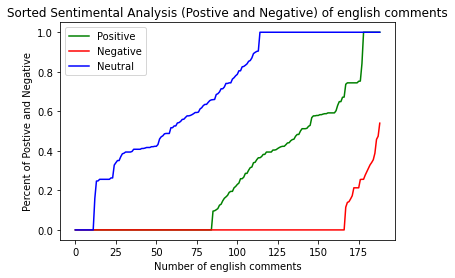

The quantity of comments
The quantity of Positive: 28
The quantity of Negative: 0
The quantity of Neutral: 112
The quantity of rest comments: 49
The quantity of overall or total coements: 189




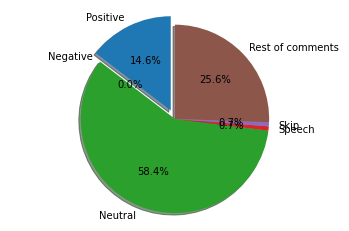

The quantity of comments
The quantity of Positive: 28
The quantity of Negative: 0
The quantity of Neutral: 112
The quantity of rest comments: 49
The quantity of overall or total coements: 189


Ratio of comments in percents
Positive comments percents: 15%
Negative comments percents: 0%
Neutral comments percents: 59%
Rest of comments percents: 26%


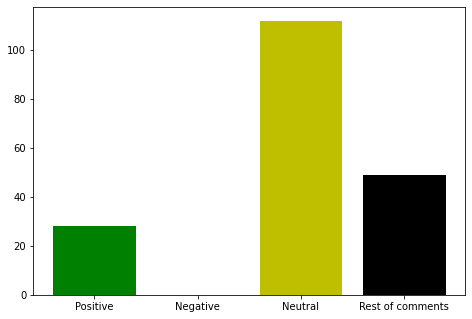

The quantity of comments
The quantity of Positive: 28
The quantity of Negative: 0
The quantity of Neutral: 112
The quantity of rest comments: 49
The quantity of overall or total coements: 189




In [115]:
# Visualization of English comments with percens 
# you can use dictionary there pisitve X + 1 (1nd col) and negative X + 2 (2nd col) is key or X axis  

# English coments sentiemnt analysis
sia = SentimentIntensityAnalyzer()
# 1. Lemmatized English words in sentences
sentiments = [comment_is_positive_percents(sia, comment) for comment in FromWordsToSentences(lemmatizedenglishwords)] 

# 2. Just English sentences
#sentiments = [CommentIsPositivePercents(sia, comment) for comment in englishcomments] 

# Create X and Y axis 
x_num = list(range(0, len(lemmatizedenglishwords)))
y_pos = GetSentiementByKey(sentiments, 0)
y_neg = GetSentiementByKey(sentiments, 1)
y_neu = GetSentiementByKey(sentiments, 2)

#0 - 1 
overall = len(x_num)
quantity_pos = Count(y_pos)
quantity_neg = Count(y_neg)
quantity_neu = Count(y_neu)
quantity_rest = (overall - quantity_pos - quantity_neg - quantity_neu)

# Draw plot
plt.figure(figsize=(15,3))
plt.title('Unsorter Sentimental Analysis (Postive and Negative) of english comments')
plt.ylabel('Percent of Postive and Negative')
plt.xlabel('Number of english comments')
plt.plot(x_num, y_pos, "-g")
plt.plot(x_num, y_neg, "-r")
plt.plot(x_num, y_neu, "-b")
plt.legend(['Positive', 'Negative', 'Neutral'])
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {overall}")
print("\n\r")

y_sorted_pos = sorted(y_pos)
y_sorted_neg = sorted(y_neg)
y_sorted_neu = sorted(y_neu)

# Draw plots
plt.title('Sorted Sentimental Analysis (Postive and Negative) of english comments')
plt.ylabel('Percent of Postive and Negative')
plt.xlabel('Number of english comments')
plt.plot(x_num, y_sorted_pos, "-g")
plt.plot(x_num, y_sorted_neg, "-r")
plt.plot(x_num, y_sorted_neu, "-b")
plt.legend(['Positive', 'Negative', 'Neutral'])
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {len(x_num)}")
print("\n\r")

# Display overall info 

# Calculation of ratio
# Positive ratio
#overall = 100%
#pos_of_comments = percent

# Negative ratio
#overall = 100%
#neg_of_comments = percent

# Rest ratio
#overall = 100%
#rest_of_comments = percent

pos_percent = (quantity_pos * 100 / overall)
neg_percent = (quantity_neg * 100 / overall)
neu_percent = (quantity_neu * 100 / overall)
rest_percent = (quantity_rest * 100 / overall)

labels = 'Positive', 'Negative', 'Neutral', 'Speech', 'Skip', 'Rest of comments'
sizes = [pos_percent, neg_percent, neu_percent, speech_percent, skip_percent, rest_percent]
explode = (0.1, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {overall}")
print("\n\r")

print(f"Ratio of comments in percents")
print(f"Positive comments percents: {round(pos_percent)}%")
print(f"Negative comments percents: {round(neg_percent)}%")
print(f"Neutral comments percents: {round(neu_percent)}%")
print(f"Rest of comments percents: {round(rest_percent)}%")

# Draw chart bar
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiments = ['Positive', 'Negative', 'Neutral', 'Rest of comments']
comments = [quantity_pos, quantity_neg, quantity_neu, quantity_rest]
ax.bar(sentiments, comments, color = ['g', 'r', 'y', 'k'])
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {overall}")
print("\n\r")


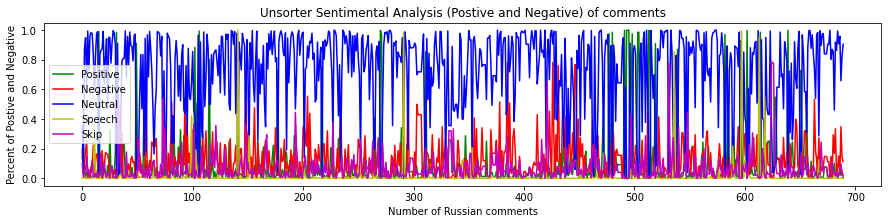

The quantity of comments
The quantity of Positive: 32
The quantity of Negative: 7
The quantity of Neutral: 497
The quantity of Speech: 5
The quantity of Skip: 5
The quantity of rest comments: 144
The quantity of overall or total coements: 690




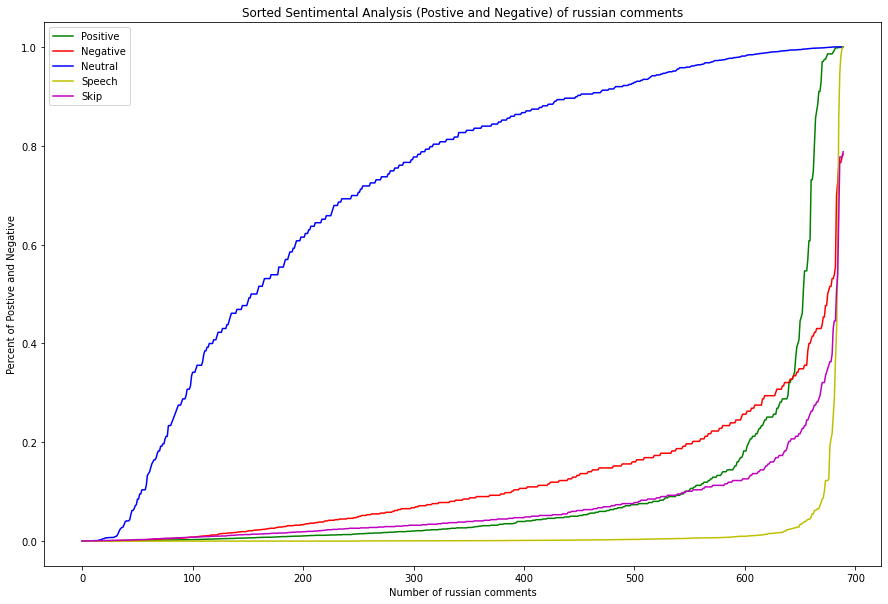

The quantity of comments
The quantity of Positive: 32
The quantity of Negative: 7
The quantity of Neutral: 497
The quantity of Speech: 5
The quantity of Skip: 5
The quantity of rest comments: 144
The quantity of overall or total coements: 690




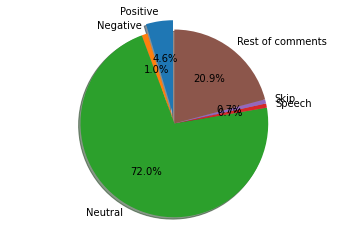

The quantity of comments
The quantity of Positive: 32
The quantity of Negative: 7
The quantity of Neutral: 497
The quantity of Speech: 5
The quantity of Skip: 5
The quantity of rest comments: 144
The quantity of overall or total coements: 690


Ratio of comments in percents
Positive comments percents: 5%
Negative comments percents: 1%
Neutral comments percents: 72%
Speech comments percents: 1%
Skip comments percents: 1%
Rest of comments percents: 21%


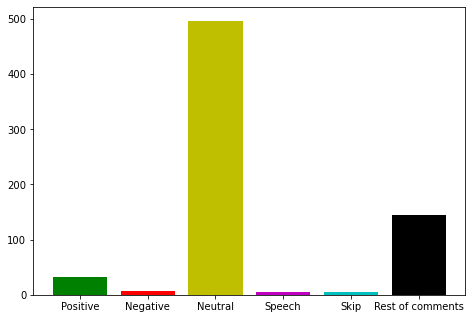

The quantity of comments
The quantity of Positive: 32
The quantity of Negative: 7
The quantity of Neutral: 497
The quantity of Speech: 5
The quantity of Skip: 5
The quantity of rest comments: 144
The quantity of overall or total coements: 690




In [114]:
# Visualization of Russian comments with percents
sentiments = GetRussianSentimentsFrom(russiancomments, pathModel)

x_num = list(range(0, len(russiancomments)))
y_pos = GetSentiementByKey(sentiments, 'positive')
y_neg = GetSentiementByKey(sentiments, 'negative')
y_neu = GetSentiementByKey(sentiments, 'neutral')
y_speech = GetSentiementByKey(sentiments, 'speech')
y_skip = GetSentiementByKey(sentiments, 'skip')
    
overall = len(x_num)
quantity_pos = Count(y_pos)
quantity_neg = Count(y_neg)
quantity_neu = Count(y_neu)
quantity_speech = Count(y_speech)
quantity_skip = Count(y_skip)
quantity_rest = (overall - quantity_pos - quantity_neg - quantity_neu - quantity_speech - quantity_skip)

# Draw plot   
plt.figure(figsize=(15,3))
plt.title('Unsorter Sentimental Analysis (Postive and Negative) of comments')
plt.ylabel('Percent of Postive and Negative')
plt.xlabel('Number of Russian comments')
plt.plot(x_num, y_pos, "-g")
plt.plot(x_num, y_neg, "-r")
plt.plot(x_num, y_neu, "-b")
plt.plot(x_num, y_speech, "-y")
plt.plot(x_num, y_skip, "-m")
plt.legend(['Positive', 'Negative', 'Neutral', 'Speech', 'Skip'])
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of Speech: {quantity_speech}")
print(f"The quantity of Skip: {quantity_skip}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {len(x_num)}")
print("\n\r")

y_sorted_pos = sorted(y_pos)
y_sorted_neg = sorted(y_neg)
y_sorted_neu = sorted(y_neu)
y_sorted_speech = sorted(y_speech)
y_sorted_skip = sorted(y_skip)

# Draw plots
plt.figure(figsize=(15,10))
plt.title('Sorted Sentimental Analysis (Postive and Negative) of russian comments')
plt.ylabel('Percent of Postive and Negative')
plt.xlabel('Number of russian comments')
plt.plot(x_num, y_sorted_pos, "-g")
plt.plot(x_num, y_sorted_neg, "-r")
plt.plot(x_num, y_sorted_neu, "-b")
plt.plot(x_num, y_sorted_speech, "-y")
plt.plot(x_num, y_sorted_skip, "-m")
plt.legend(['Positive', 'Negative', 'Neutral', 'Speech', 'Skip'])
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of Speech: {quantity_speech}")
print(f"The quantity of Skip: {quantity_skip}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {len(x_num)}")
print("\n\r")

# Display overall info 

# Calculation of ratio
# Positive ratio
#overall = 100%
#pos_of_comments = percent

# Negative ratio
#overall = 100%
#neg_of_comments = percent

# Rest ratio
#overall = 100%
#rest_of_comments = percent

pos_percent = (quantity_pos * 100 / overall)
neg_percent = (quantity_neg * 100 / overall)
neu_percent = (quantity_neu * 100 / overall)
speech_percent = (quantity_speech * 100 / overall)
skip_percent = (quantity_skip * 100 / overall)

rest_percent = (quantity_rest * 100 / overall)

labels = 'Positive', 'Negative', 'Neutral', 'Speech', 'Skip', 'Rest of comments'
sizes = [pos_percent, neg_percent, neu_percent, speech_percent, skip_percent, rest_percent]
explode = (0.1, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of Speech: {quantity_speech}")
print(f"The quantity of Skip: {quantity_skip}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {overall}")
print("\n\r")

print(f"Ratio of comments in percents")
print(f"Positive comments percents: {round(pos_percent)}%")
print(f"Negative comments percents: {round(neg_percent)}%")
print(f"Neutral comments percents: {round(neu_percent)}%")
print(f"Speech comments percents: {round(speech_percent)}%")
print(f"Skip comments percents: {round(skip_percent)}%")
print(f"Rest of comments percents: {round(rest_percent)}%")

# Draw chart bar
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sentiments = ['Positive', 'Negative', 'Neutral', 'Speech', 'Skip', 'Rest of comments']
comments = [quantity_pos, quantity_neg, quantity_neu, quantity_speech, quantity_skip, quantity_rest]
ax.bar(sentiments, comments, color = ['g', 'r', 'y', 'm', 'c', 'k'])
plt.show()

print(f"The quantity of comments")
print(f"The quantity of Positive: {quantity_pos}")
print(f"The quantity of Negative: {quantity_neg}")
print(f"The quantity of Neutral: {quantity_neu}")
print(f"The quantity of Speech: {quantity_speech}")
print(f"The quantity of Skip: {quantity_skip}")
print(f"The quantity of rest comments: {quantity_rest}")
print(f"The quantity of overall or total coements: {overall}")
print("\n\r")

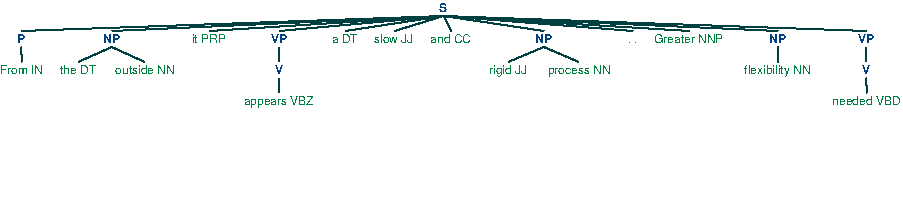

In [97]:
CrateTree(FromWordsToSentence(englishWords[0]), outputPath)
convert_to_png(path)
Image.open(nltkTreePath) 

In [ ]:
# Tests outputs
print(russiancomments)
print(len(russiancomments))
print(len(russianWords))
print(russianWords)
print(englishWords)
print(lemmatizedenglishwords)

In [99]:
# Test lemmatizing word verb
# went = verb
word = "went" 
tag = GetWordnetPos(word)
lemmatized = LemmatizingWord(word, tag)
print(f"Grammar or tag: {tag}, Lemmatized form: {lemmatized}")

Grammar or tag: v, Lemmatized form: go


In [ ]:
# Tests lemmatizering noun plural'
# ribs = rib
word = "ribs" 
tag = GetWordnetPos(word)
lemmatized = LemmatizingWord(word, tag)
print (f"Grammar or tag: {tag}, Lemmatized: {lemmatized}")

In [ ]:
# Tests lemmatizaztion outputs
print(f"Lemmatized: {lemmatizedenglishwords[:3]}")
print(f"Words: {englishWords[:3]}")